## Package prerequisites

In this part, the following libraries need to be imported.

In [110]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mplsoccer import Pitch, VerticalPitch
import seaborn as sns
%config InlineBackend.figure_formats = ['png']

## Exploratory Data Analysis

First of all, I read a preprocessed (see Part 1 and Part 2) `.csv` data file and convert all required columns to python readable object types. 

In [3]:
# read shots.csv file 
shots = pd.read_csv('.data/shots.csv')
shots.loc[:, 'freeze_frame'] = shots.loc[:, 'freeze_frame'].apply(ast.literal_eval)
shots.loc[:, 'gk_loc'] = shots.loc[:, 'gk_loc'].apply(ast.literal_eval)
shots.loc[:, 'end_loc'] = shots.loc[:, 'end_loc'].apply(ast.literal_eval)

Prediction of a goal outcome in soccer is a binary classification task { 0 - No goal ; 1 - Goal }. However, the key point to note is that, in xG model, we are not dealing with hard classes but rather trying to make a probabilistic prediction for a shot outcome. In comparison with hard classes, probabilistic outputs allow to better understand the quality of shot. In other words,  given a shot, how likely it is to result into a goal. This is what xG value estimates for a given shot. 

As you can see from below code snippet, there are different outcome types for a given shot such as *Saved*, *Off target*, shot that hit *Post*, *Blocked*, way off target *Wayward* shot and etc. To build a binary probabilistic classifier, it is necessary for us to define predictions as hard classes. Here, I convert each value of `outcome_type` column to 1 for *Goal* scenario or 0 for the rest of scenarios.

In [5]:
shots.loc[:, 'outcome'].unique()

array(['Saved', 'Off T', 'Post', 'Goal', 'Blocked', 'Wayward',
       'Saved Off Target', 'Saved to Post'], dtype=object)

In [22]:
# rename existing 'outcome' column to 'outcome_type' 
shots = shots.rename(columns = {'outcome': 'outcome_type'})
# save binary results into a newly created 'outcome' column
shots.loc[:, 'outcome'] = shots.loc[:, 'outcome_type'].apply(lambda x: 1 if x == 'Goal' else 0)
shots.loc[:, 'outcome']

0        0
1        0
2        0
3        0
4        0
        ..
11038    0
11039    0
11040    0
11041    0
11042    0
Name: outcome, Length: 11043, dtype: int64

Now, let us analyze the types of available shots and their corresponding distribution. From @fig-1 it can be seen that our dataframe has a data on 11043 shots. As we can see below, 1165 of them resulted into a goal.

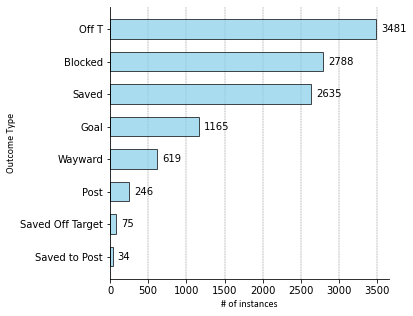

In [138]:
#| label: fig-1 
#| fig-cap: "Distribution of shot outcomes across female soccer competitions."

shot_types = pd.DataFrame(shots.loc[:, 'outcome_type'].value_counts()).reset_index()
shot_types.columns = ['outcome_type', 'n']
shot_types = shot_types.sort_values(by = 'n', ascending = True)

# Canvas
fig, ax = plt.subplots(figsize = (5, 5))

# grid specs
ax.grid(color = 'black', ls = '-.', lw = 0.25, axis = "x")

# Main plot
pl = ax.barh(shot_types["outcome_type"], shot_types["n"], height = 0.6, label = 'n',
       color = 'skyblue', edgecolor = "black", zorder = 2, alpha = 0.7) 

# Barplot labels
ax.bar_label(pl, padding = 5, label_type='edge')

# Labels and titles
ax.set_ylabel("Outcome Type", fontsize = 10)
ax.set_xlabel("# of instances", fontsize = 10)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title("", loc = "left", pad = 1, fontdict = font)
ax.spines[['top', 'right']].set_visible(False)

plt.show()

To sum up, we can see that the majority of shots are off target, blocked or saved. Out of 11043 shots, only 1165 are goals. Thus, we can conclude that our data is imbalanced.

Next, we can visualize the location of all shots.

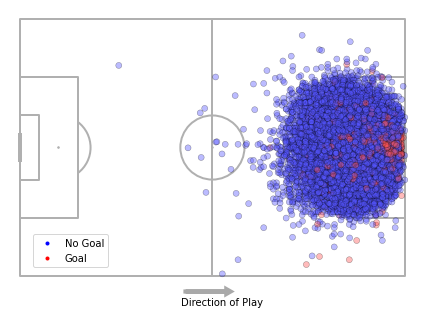

In [135]:
#| label: fig-2
#| fig-cap: "Distribution of shots according to their coordinates."

# Canvas
pitch = Pitch(pitch_type = 'statsbomb')  
fig, ax = pitch.draw(figsize=(6, 8))

sns.scatterplot(data = shots, x = 'x_start', y = 'y_start', ax = ax,
                hue = 'outcome', palette = 'seismic', edgecolor = 'black', alpha = 0.4)

# legend design
from matplotlib.lines import Line2D

custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]

plt.legend(custom, ['No Goal', 'Goal'], bbox_to_anchor=(0.05, 0.21))

# Arrow 
arrow_ax = fig.add_axes([0.28, 0.22, 0.35, 0.3]) # X, Y, width, height

arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
           color='darkgrey', length_includes_head=True)
arrow_ax.set_ylim(0, 1)
arrow_ax.set_xlim(0, 1)
arrow_ax.set_axis_off()
arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


plt.show()

The majority of shots is made in the central block of the final third area. In addition, there are several outlying shots made from a central area and flang positions. On the right flang, some of outliers even resulted into *Goal*.

## Feature Engineering

When it comes to the analysis of a shot made by a player, first of all, one can even intuitively predict whether that shot will have a decent outcome or not. In practice, there are two major factors which drive that intuition and can be actually quantified. These are **distance** to goal and **angle** under which shot was implemented.

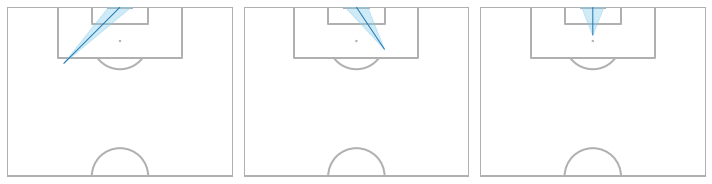

In [397]:
#| label: fig-3
#| fig-cap: "Different distance to goal (solid line) and angle (shaded area) for a given shot."

%config InlineBackend.figure_formats = ['png']

# Visual shots on Pitch
pitch = VerticalPitch(pitch_type = 'statsbomb',
                      half = True, 
                      pad_left = 0, pad_right = 0, pad_top = 0, pad_bottom = 0.15)  
fig, ax = pitch.draw(nrows = 1, ncols = 3, figsize=(10, 12))

x = np.array([100, 120, 105, 120, 110, 120]).reshape(3, 2)
y = np.array([20, 40, 50, 40, 40, 40]).reshape(3, 2)
for i in range(3):

    pitch.goal_angle(x[i][0], y[i][0], ax = ax[i], alpha = 0.4, color = 'skyblue')
    pitch.lines(x[i][0], y[i][0], x[i][1], y[i][1], ax = ax[i], linewidth = 1)


plt.show()

### Distance & Angle Features

To demonstrate an impact of **distance** and **angle** features on a probability of a shot resulting into a goal, I evaluate these features from a given (x, y) coordinate of each shot and build a simple logistic regression that makes probabilitistic predictions.

To evaluate distance to the goal, I calculate euclidean distance between (x, y) coordinate of a shot and goal centerline. Since I work with Statsbomb data, I use their pitch dimensions which are [0, 120] on x axis and [0, 80] on y axis. Thus, goal centerline coordinates are (120, 40).

Below, you can see my implementation:

In [237]:
#| code-fold: false
# Distance Feature calculation

# define goal center for 'statsbomb'
goal_center = np.array([120, 40])

# calculate distance between shot and goal center
shots['distance'] = np.sqrt((shots['x_start'] - goal_center[0])**2 + (shots['y_start'] - goal_center[1])**2)
shots['distance'] = shots['distance'].round(decimals = 2)

Next, I calculate angle of a shot. To evaluate angle (alpha) of a shot, our task breaks down to finding an angle between two sides of a triangle given that all lengths (a, b, c) of triangle are known.

Below, you can see my implementation:

In [238]:
#| code-fold: false
# Angle Feature calculation

# transform x, y coordinates from percentiles to field length coordinates (105 meters x 68 meters)
x = shots['x_start'] * 105/120
y = shots['y_start'] * 68/80 

# Use trigonometric formula to find angle between two sides (a,b) of triangle where third side (c) 
# is a goal line of length 7.32
a = np.sqrt((x - 105)**2 + (y - 30.34)**2) # length between right post and (x,y) shot coordinate
b = np.sqrt((x - 105)**2 + (y - 37.66)**2) # length between left post and (x,y) shot coordinate
c = 7.32 # goal line length in meters
cos_alpha = (a**2 + b**2 - c**2)/(2*a*b)
cos_alpha = np.round(cos_alpha, decimals = 4)

# remember to leave angle in radians (if you want to transfer to degree multiply cos_alpha by 180/pi)
shots['angle'] = np.arccos(cos_alpha)

Now, I would like to demonstrate how both of these features impact probability of scoring.

I run a simple logistic regression that includes only these features (distance, angle) and obtain probabilisitc predictions for each shot. Then, I plot both of these features against my probabilistic predictions to visualize the relationship. This is a raw model which does not make any kinds of feature preprocessing since the goal here is to illustrate relationship between our features and probability of scoring.

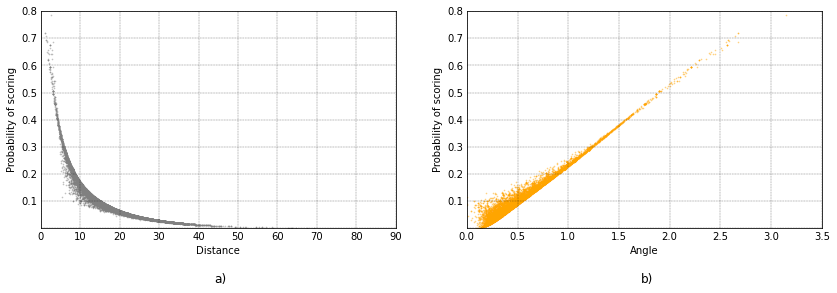

In [394]:
#| label: fig-4
#| fig-cap: "Probability of scoring decreases with increasing distance (a) and increases with increasing angle (b)."

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Prepare features and labels from available data
X = shots.loc[:, ['distance', 'angle']]
y = shots.loc[:, 'outcome']

# Fit Logistic Regression Model
xG_model = LogisticRegression()
xG_model.fit(X, y)

# make predictions
xG_predictions = xG_model.predict_proba(X)[:, 1]


# Canvas
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))

# Distance plot design

# grid
ax[0].grid(color = 'black', ls = '-.', lw = 0.25, axis = "both")

# plot
ax[0].scatter(X['distance'], xG_predictions, color = 'gray', s = 0.5, alpha = 0.4)
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Probability of scoring')

# axis adjustments
ax[0].set_ylim(0, 0.8)
ax[0].set_xlim(0, 90)
ax[0].yaxis.get_major_ticks()[0].label1.set_visible(False)
ax[0].tick_params(length = 0)

############################################

# Angle plot design

# grid
ax[1].grid(color = 'black', ls = '-.', lw = 0.25, axis = "both")

# plot
ax[1].scatter(X['angle'], xG_predictions, color = 'orange', s = 0.5, alpha = 0.4)
ax[1].set_xlabel('Angle')
ax[1].set_ylabel('Probability of scoring')

# axis adjustments
ax[1].set_ylim(0, 0.8)
ax[1].set_xlim(0, 3.5)
ax[1].yaxis.get_major_ticks()[0].label1.set_visible(False)
ax[1].tick_params(length = 0)

ax[0].text(x = 44, y = -0.2, s = 'a)', fontsize = 12)
ax[1].text(x = 1.72, y = -0.2, s = 'b)', fontsize = 12)


plt.show()

As it can be seen from a) part of @fig-4, indeed, probability of scoring (or you can also call it xG value) decreases exponentially with increasing distance. On the contrast, probability of scoring increases in a linear shape with increasing angle.

In both plots of @fig-4, there are densely populated parts that can be analyzed in a slightly different way. These are the areas  from where majority of shots is executed. When analyzing @fig-5, we can observe that most of the shots are executed within a distance range of 5 to 30 meters. Similarly, most of the angles of executed shots are distributed within 0 to 60 degrees (0 to 1 radian respectively).

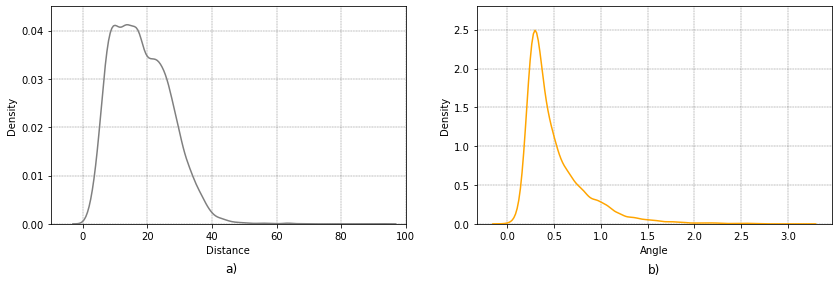

In [393]:
#| label: fig-5
#| fig-cap: " Distribution of distances (a) and angles for shots (b)."

# Canvas
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))

# Distance density plot design
ax[0].grid(color = 'black', ls = '-.', lw = 0.25, axis = "both")
sns.kdeplot(x = 'distance', data = shots, ax = ax[0], color = 'gray')
ax[0].set_xlabel('Distance')
ax[0].set_ylim(0, 0.045)
ax[0].set_yticks(np.arange(0, 0.045, 0.01))
ax[0].set_xlim(-10, 100)


# Angle density plot design
ax[1].grid(color = 'black', ls = '-.', lw = 0.25, axis = "both")
sns.kdeplot(x = 'angle', data = shots, ax = ax[1], color = 'orange')
ax[1].set_xlabel('Angle')
ax[1].set_ylim(0, 2.8)

ax[0].text(x = 44, y = -0.01, s = 'a)', fontsize = 12)
ax[1].text(x = 1.5, y = -0.63, s = 'b)', fontsize = 12)


plt.show()

## Statistical Analysis of Features

I run a logistic regression including  all features that could help me understand the statistical signficance of these features. My intention is to analyze p-values for each of the features, and determine which of those values are weakly associated with the response.

In [428]:
X = shots.loc[:, ['play_pattern_name','under_pressure', 'distance', 'angle', 'gk_loc_x', 'gk_loc_y',
                   'follows_dribble', 'first_time', 'open_goal', 'technique', 'body_part']]
y = shots.loc[:, 'outcome']

df_train = pd.concat([X, y], axis = 1).reset_index(drop = True)

import statsmodels.formula.api as smf

# run model
logreg_model = smf.logit(
    formula = "outcome ~ distance + angle + under_pressure + gk_loc_y + gk_loc_x + \
    body_part + open_goal + play_pattern_name",
                         data = df_train).fit()

pd.DataFrame(logreg_model.pvalues, columns = ['p-value']).round(decimals = 3)

Optimization terminated successfully.
         Current function value: 0.284721
         Iterations 8


,p-value
Intercept,0.000
body_part[T.Left Foot],0.000
body_part[T.Other],0.642
body_part[T.Right Foot],0.000
play_pattern_name[T.From Counter],0.001
play_pattern_name[T.From Free Kick],0.000
play_pattern_name[T.From Goal Kick],0.000
play_pattern_name[T.From Keeper],0.203
play_pattern_name[T.From Kick Off],0.239
play_pattern_name[T.From Throw In],0.001


There are several categorical variables which have very high p-values. These are **body_part[T.Other]**, **play_pattern_name[T.From Keeper]**,  **play_pattern_name[T.From Kick Off]**, **play_pattern_name[T.Other]** and **gk_loc_y**. Let us break down those features and consider if we can leave them out of our model.

First, there is a **play_pattern_name** column that describes different attacking phases in which a shot was executed. As it can be seen from below code snippet, there are in total 9 attacking phases.

In [431]:
shots.loc[:, 'play_pattern_name'].unique()

array(['Regular Play', 'From Free Kick', 'From Throw In', 'From Counter',
       'From Corner', 'From Keeper', 'From Goal Kick', 'From Kick Off',
       'Other'], dtype=object)

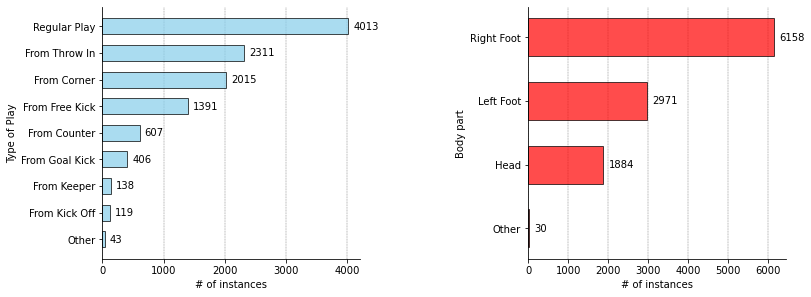

In [454]:
#| label: fig-6
#| fig-cap: "Distribution of shots in different types of play (left) and implemented with different parts of body (right)."

play_types = pd.DataFrame(shots.loc[:, 'play_pattern_name'].value_counts()).reset_index()
play_types.columns = ['play_pattern_name', 'n']
play_types = play_types.sort_values(by = 'n', ascending = True)

body_part = pd.DataFrame(shots.loc[:, 'body_part'].value_counts()).reset_index()
body_part.columns = ['body_part', 'n']
body_part = body_part.sort_values(by = 'n', ascending = True)


# Canvas
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 5))

# grid specs
ax[0].grid(color = 'black', ls = '-.', lw = 0.25, axis = "x")

# Main plot
pl = ax[0].barh(play_types["play_pattern_name"], play_types["n"], height = 0.6, label = 'n',
       color = 'skyblue', edgecolor = "black", zorder = 2, alpha = 0.7) 

# Barplot labels
ax[0].bar_label(pl, padding = 5, label_type='edge')

# Labels and titles
ax[0].set_ylabel("Type of Play", fontsize = 10)
ax[0].set_xlabel("# of instances", fontsize = 10)
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 10)
ax[0].set_title("", loc = "left", pad = 1, fontdict = font)
ax[0].spines[['top', 'right']].set_visible(False)

#############################################################################

# grid specs
ax[1].grid(color = 'black', ls = '-.', lw = 0.25, axis = "x")

# Main plot
pl2 = ax[1].barh(body_part["body_part"], body_part["n"], height = 0.6, label = 'n',
       color = 'red', edgecolor = "black", zorder = 2, alpha = 0.7) 

# Barplot labels
ax[1].bar_label(pl2, padding = 5, label_type='edge')

# Labels and titles
ax[1].set_ylabel("Body part", fontsize = 10)
ax[1].set_xlabel("# of instances", fontsize = 10)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 10)
ax[1].set_title("", loc = "left", pad = 1, fontdict = font)
ax[1].spines[['top', 'right']].set_visible(False)


# set the spacing between subplots
plt.subplots_adjust(left = 0.1,
                    bottom = 1.3, 
                    right = 2, 
                    top = 2, 
                    wspace = 0.65, 
                    hspace = 0.5)

plt.show()


Features **play_pattern_name[T.From Keeper]**,  **play_pattern_name[T.From Kick Off]**, **play_pattern_name[T.Other]** that received high p-values are actually very rare events and can be considered as outliers in our model. There are very few situations in which attack starting from goalkeeper or from a kick-off can result into a goal. From @fig-6, it can be seen that in total 300 shots were executed in types of play: 'From Keeper', 'From Kick Off' and 'Other'.

In [470]:
print(np.sum(shots.loc[shots['play_pattern_name'] == 'From Keeper', 'outcome']), 
     'goals were scored when attack was initiated from goal keeper.',)

13 goals were scored when attack was initiated from goal keeper.


In [471]:
print(np.sum(shots.loc[shots['play_pattern_name'] == 'From Kick Off', 'outcome']),
      'goals were scored when attack was initiated from kick-off.')

10 goals were scored when attack was initiated from kick-off.


In [472]:
print(np.sum(shots.loc[shots['play_pattern_name'] == 'Other', 'outcome']),
      'goals were scored when attack was initiated from other scenarios.')

7 goals were scored when attack was initiated from other scenarios.


In total, only 30 out of those 300 shots were scored.

Similar pattern can be observed when analyzing `body_part` categorical column and **body_part[T.Other]** feature that received a high p-value in our logistic regression. Out of 11043 shots available in our dataset, only 30 shots were executed with body part other than foot or head.

In [475]:
print('Only', np.sum(shots.loc[shots['body_part'] == 'Other', 'outcome']),
      'goals out of 30 shots were scored when body part other than foot or head.')

Only 6 goals out of 30 shots were scored when body part other than foot or head.


To sum up both of these scenarios, we see that there are only 330 shots and 36 goals which fall into this outlying conditions. This is a relatively small sample size in comparison to the available data, thus, I exclude this data points from the dataset.

In [489]:
shots = shots.loc[~((shots['play_pattern_name'] == 'Other') | (shots['play_pattern_name'] == 'From Keeper' ) 
| (shots['play_pattern_name'] == 'From Kick Off') | (shots['body_part'] == 'Other')),  :]

Finally, there is one more column `gk_loc_y` which also has a high p-value. This column together with `gk_loc_x` describe a location of goalkeeper during an executed shot. Naturally, goalkeeper standing on the goal line mainly can move differently but in most of the cases along the goal line. This means that her/his y coordinate should change much more frequently than x coordinate. However, what we see is that y coordinate is less significant in our model than x coordinate. As of now, I will leave both of these features in the dataset and will their impact again later when evaluating model performance with different algorithms.

## Transforming and Splitting Data

In [517]:
from sklearn.model_selection import train_test_split
# Prepare features and labels from available data
X = shots.loc[:, ['play_pattern_name','under_pressure', 'distance', 'angle', 'gk_loc_x',
                   'follows_dribble', 'first_time', 'open_goal', 'technique', 'body_part']]
y = shots.loc[:, 'outcome']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [518]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['play_pattern_name', 'technique', 'body_part']),
    ('std_coords', StandardScaler(), ['distance', 'angle', 'gk_loc_x'])],
    remainder = 'passthrough', verbose_feature_names_out = True)

X_train_trans = column_trans.fit_transform(X_train)

## Models' Comparison

**Logistic Regression | Default Approach**

In [519]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

# Fit Logistic Regression Model
xG_model = LogisticRegression()
xG_model.fit(X_train_trans, y_train)

# evaluate
xG_predictions = xG_model.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7932825029297309

In [520]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = xG_model.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7444304100699057

In [521]:
brier_score_loss(y_valid, xG_predictions)

0.07530598392177701

**Gradient Boosting | Best Performer**

In [522]:
# features used:
# X = shots.loc[:, ['play_pattern_name','under_pressure', 'distance', 'angle', 'gk_loc_x', 'gk_loc_y',
#                   'follows_dribble', 'first_time', 'open_goal', 'technique', 'body_part']]

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.035, loss = 'exponential',
    random_state=0).fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.8523929552072906

In [523]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7422036629717546

In [524]:
brier_score_loss(y_valid, xG_predictions)

0.07677725372860654

**MLP | Not enough data to improve performance**

In [525]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, activation = 'tanh', hidden_layer_sizes = (80, 80, 30, 30), alpha = 0.0001, 
#                     learning_rate = 'adaptive', 
                    solver = 'sgd',
                    max_iter = 700).fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7883354146095913

In [526]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7484701321892898

In [513]:
brier_score_loss(y_valid, xG_predictions)

0.07539088442913291

**Random Forrest | Performance Close to Gradient Boosting**

In [527]:
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(max_depth = 10, random_state = 12, criterion = 'entropy')
clf = RandomForestClassifier(max_depth = 10, random_state = 12, criterion = 'entropy')
clf.fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.9121693589441353

In [528]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7357738626712255

In [529]:
brier_score_loss(y_valid, xG_predictions)

0.07679120654707627